# Stimulus-driven predictive model of brain activity.
What we will need:
- The betas and experiment 'per-subject' stimuli blocks generated in 'data_preparation' notebook.
- The reference and new model parameters (which include a mask of voxels that have been used in the training of these model).

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import src.numpy_utility as pnu
import src.fwrf as fwrf
from src.fwrf import fpX
from src.file_utility import save_stuff

Using cuDNN version 5103 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:05:00.0)

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [3]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [4]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 60, 'frameon': False}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'deepnet-fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
output_dir = root_dir+"output/S%02d/" % subject
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Time Stamp: %s" % timestamp

Time Stamp: Aug-15-2019_1530


## Model file paths

In [6]:
ref_model_file_name = output_dir + 'temp_fwrf_Aug-01-2019_1357_data.h5py'
new_model_file_name = output_dir + 'trained_model_Aug-11-2019_1609.pkl'

# Load the stimuli images

In [5]:
nsd_root = "/repo.local2/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

In [5]:
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
exp_design = loadmat(exp_design_file)

In [6]:
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
print ordering.shape
print np.min(ordering), np.max(ordering)

(30000,)
0 9999


In [7]:
image_data_set = h5py.File(stim_root + "S%d_stimuli.h5py"%subject)
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print image_data.shape
print image_data.dtype
print np.min(image_data[0]), np.max(image_data[0])

(10000, 3, 227, 227)
uint8
0 255


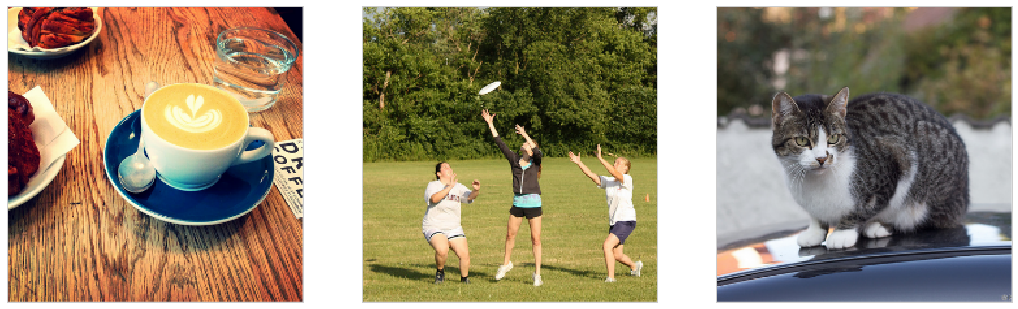

In [8]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# COCO stuff
## The cocoID of the image block (array contains all subjects)

In [9]:
coco_info_set = h5py.File(stim_root + 'nsd_to_coco_indice_map.h5py')
cocoId_arr = np.copy(coco_info_set['cocoId'])
nsdcrop_arr = np.copy(coco_info_set['crop'])
coco_info_set.close()

## The supercategory annotation maps corresponding to the image block

In [127]:
label_data_set = h5py.File(stim_root + "S%d_supercategory_227.h5py"%subject)
label_data = np.copy(label_data_set['labels'])
label_count = np.copy(label_data_set['label_count'])
label_data_set.close()

label_map_file = open(stim_root + "S%d_supercategory_227_label_map.pkl"%subject, 'rb')
label_map = pickle.load(label_map_file)
label_map_file.close()

print label_data.shape
print label_data.dtype
print 'values', np.min(label_data), '--', np.max(label_data)
print label_map

(10000, 227, 227)
uint8
0 27


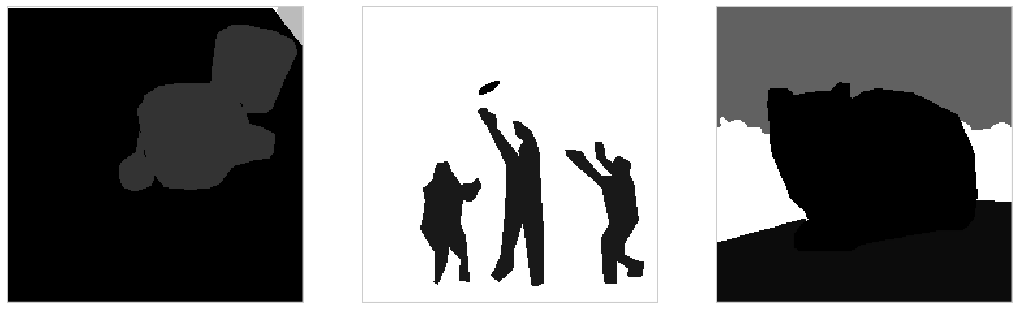

In [131]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(label_data[6+i], cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

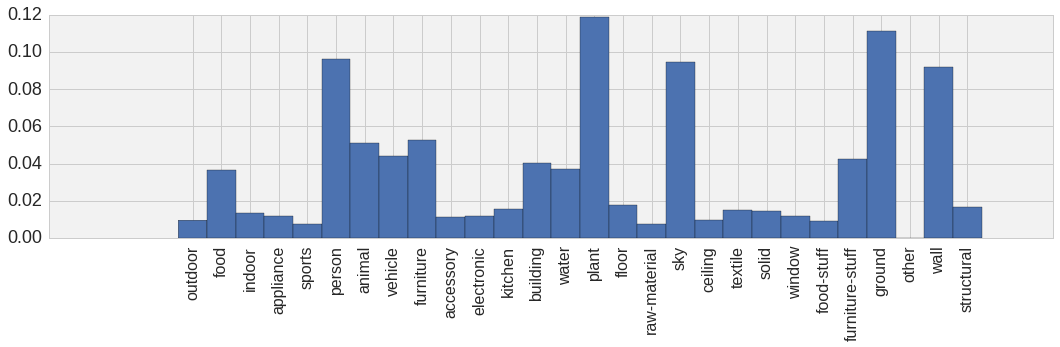

In [151]:
plt.figure(figsize=(18,4))
_=plt.hist(label_data.flatten(), bins=np.arange(0,label_count+1,1), normed=True,align='left')
_=plt.gca().set_xticks(np.arange(label_count))
_=plt.gca().set_xticklabels([label_map[k] for k in np.arange(label_count)], rotation=90, fontdict=\
        {'fontsize': 16,
         'fontweight': 'normal',
         'verticalalignment': 'top',
         'horizontalalignment': 'center'})

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [10]:
from src.file_utility import load_mask_from_nii, view_data

In [11]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4', 8: 'VO1', 9: 'VO2', \
           10: 'PHC1', 11: 'PHC2', 12: 'MST', 13: 'hMT', 14: 'LO2', 15: 'LO1', 16: 'V3b', 17: 'V3a', \
           18: 'IPS0', 19: 'IPS1', 20: 'IPS2', 21: 'IPS3', 22: 'IPS4', 23: 'IPS5', 24: 'SPL1', 25: 'FEF'}

In [12]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(nsd_root + "mask/subj%02d/subj%02d_mean_mask.nii.gz"%(subject,subject))
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_mask_full = brain_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]

general_mask_full = (general_mask_full==1).flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(brain_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]

## Display a slice of the data

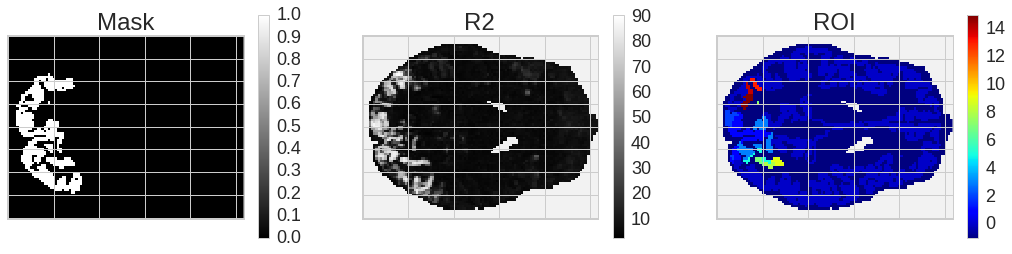

In [13]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [14]:
def load_betas(folder_name, zscore=False, voxel_mask=None):
    from src.file_utility import list_files
    matfiles = []
    betas = []
    for filename in list_files(folder_name):
        if ".mat" in filename:
            matfiles += [filename,]
            print filename
            ##
            beta_data_set = h5py.File(filename)
            values = np.copy(beta_data_set['betas'])
            print values.shape
           
            if voxel_mask is None:
                betas += [values.reshape((len(values), -1), order='F').astype(np.float32) / 300.,]
            else:
                betas += [values.reshape((len(values), -1), order='F')[:,voxel_mask.flatten()].astype(np.float32) / 300.,]
            beta_data_set.close()
            if zscore: 
                mb = np.mean(betas[-1], axis=0, keepdims=True)
                sb = np.std(betas[-1], axis=0, keepdims=True)
                
                betas[-1] = np.nan_to_num((betas[-1] - mb) / (sb + 1e-6))
                print "<beta> = %.3f, <sigma> = %.3f" % (np.mean(mb), np.mean(sb))
                
    return np.concatenate(betas, axis=0), matfiles

voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=general_mask_full)
print voxel_data.shape

/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
(750, 83, 104, 81)
<beta> = 1.066, <sigma> = 0.915
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
(750, 83, 104, 81)
<beta> = 0.927, <sigma> = 0.826
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
(750, 83, 104, 81)
<beta> = 1.163, <sigma> = 0.944
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
(750, 83, 104, 81)
<beta> = 0.886, <sigma> = 0.797
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
(750, 83, 104, 81)
<beta> = 1.007, <sigma> = 0.892
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session06.mat
(750, 83, 104, 81)
<beta> = 1.111, <sigma> = 0.958
/repo.local2/datasets/

In [15]:
voxel_idx = voxel_idx_general
voxel_roi = voxel_roi_general
voxel_r2  = voxel_r2_general

## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [16]:
data_size, nv = voxel_data.shape 
print "Total number of voxels = %d" % nv

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print "Validation size =", val_size, ", Training size =", trn_size

Total number of voxels = 15660
Validation size = 1829 , Training size = 16921


- "stim_data" includes stimuli repeat. Takes more memory but it is easier to align with the single-trial voxel activity.

In [17]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data] # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

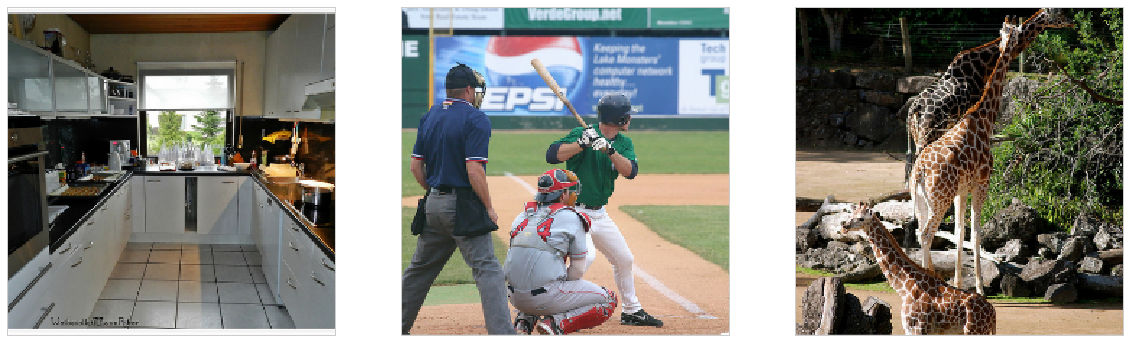

In [18]:
plt.figure(figsize=(20,20))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(val_stim_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Reload reference model prediction accuracy
- Alexnet-fwRF model with parametrized gaussian pooling field, trained elsewhere.

In [19]:
data_set = h5py.File(ref_model_file_name)
ref_val_cc = np.copy(data_set['val_cc'])
ref_rf_params = np.copy(data_set['rf_params'])
data_set.close()

# Network structure

In [20]:
def bypass_block(l_in, n_exposed, n_hiddens=0, filter_size=5, stride=2, pad=1, level=0):
    out = conv(l_in, num_filters=n_exposed+n_hiddens, \
        filter_size=filter_size, stride=stride, pad=pad, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify, name='l%d'%level)
    exp = L.SliceLayer(out, indices=slice(0, n_exposed), axis=1)
    return out, exp

def _fwrf(_fmaps, fmaps_shapes, rf_rez=(1,1), nv=1, nonlinearity=None, dtype=np.float32):
    ft_count=np.sum([s[1] for s in fmaps_shapes])
    rf_max = np.max([s[2] for s in fmaps_shapes])
    print ft_count, rf_max, rf_max
    _phi = []
    _rf = theano.shared(np.full(fill_value=1, shape=(nv,)+rf_rez).astype(dtype), name='xyRF')
    for _f,s in zip(_fmaps, fmaps_shapes):
        _v = T.reshape(T.nnet.nnet.softmax(T.reshape(_rf, (nv,np.prod(rf_rez)))), (nv,)+rf_rez)
        if rf_rez != s[2:4]:
            print 'rescale'
            u  = pnu.create_sampling_array(rf_rez, s[2:4])
            _u = theano.shared(u.reshape(s[2:4]+rf_rez).astype(dtype))
            _v = T.tensordot(_v, _u, [[1,2], [2,3]])
        #fmaps : [batch, features, y, x]   # v : [nv, y, x]
        _phi += [T.tensordot(_v, _f, [[1,2], [2,3]]),]
        #_phi : [nv, batch, features]
    ###
    _Phi = T.concatenate(_phi, axis=2)
    if nonlinearity is not None:
        _Phi = nonlinearity(_Phi)
    _w = theano.shared(np.full(fill_value=0, shape=(nv, ft_count), dtype=dtype), name='fRF')
    #_alpha = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='scale')
    _beta = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='bias')
    #theano.shared(np.random.normal(0, .02, size=(nv, ft_count)).astype(dtype), name='fRF')
    _vr = T.batched_dot(_Phi, _w).T + _beta.dimshuffle('x',0)
    #_vr = _alpha.dimshuffle('x',0) * T.batched_dot(_Phi, T.nnet.nnet.softmax(_w)).T + _beta.dimshuffle('x',0)
    #_v : [batch, nv]
    return _vr, [_rf, _w, _beta]

def _layerwise_fwrf(_fmaps, fmaps_shapes, nv=1, nonlinearity=None, dtype=np.float32):
    ft_count=np.sum([s[1] for s in fmaps_shapes])
    rf_max = np.max([s[2] for s in fmaps_shapes])
    print ft_count, rf_max, rf_max
    _phi, _rfs = [],[]
    for l,(_f,s) in enumerate(zip(_fmaps, fmaps_shapes)):
        if len(s)==4 and s[2:]!=(1,1):
            _rf = theano.shared(np.full(fill_value=1, shape=(nv,)+s[2:]).astype(dtype), name='xyRF_%d'%l)
            _v = T.reshape(T.nnet.nnet.softmax(T.reshape(_rf, (nv,np.prod(s[2:])))), (nv,)+s[2:])
            #fmaps : [batch, features, y, x]   # v : [nv, y, x]
            _phi += [T.tensordot(_v, _f, [[1,2], [2,3]]),]
            _rfs += [_rf,]
        else:
            _phi += [T.extra_ops.repeat(_f.flatten(ndim=2).dimshuffle('x',0,1), repeats=nv, axis=0)]          
        #_phi : [nv, batch, features]
    ###
    _Phi = T.concatenate(_phi, axis=2)
    if nonlinearity is not None:
        _Phi = nonlinearity(_Phi)
    _w = theano.shared(np.full(fill_value=0, shape=(nv, ft_count), dtype=dtype), name='fRF')
    _beta = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='bias')
    #theano.shared(np.random.normal(0, .02, size=(nv, ft_count)).astype(dtype), name='fRF')
    _vr = T.batched_dot(_Phi, _w).T + _beta.dimshuffle('x',0)
    #_v : [batch, nv]
    return _vr, _rfs+[_w,_beta]

In [21]:
import lasagne
import lasagne.layers as L
import lasagne.nonlinearities as NL
import lasagne.init as I

from src.lasagne_utility import deconv, conv, batch_norm, batch_norm_n, fc_concat, conv_concat, avg, flatten, sigmoid, tanh
from src.lasagne_utility import print_lasagne_network

_X = (T.TensorType('uint8', (False,)*4))()
_V = T.fmatrix()
  
_Xbar = theano.shared(np.array( [122.67891434, 116.66876762, 104.00698793] ).astype(np.float32))
_Xbar = T.patternbroadcast(_Xbar.dimshuffle(('x', 0, 'x', 'x')), (True, False, True, True))

l_in = L.InputLayer(shape=(None, 3, 227, 227), input_var=(_X.astype(theano.config.floatX) - _Xbar) / 255)
# block 1
conv1 = conv(l_in, num_filters=96, filter_size=7, stride=2, pad=0, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify) #111
pool1 = L.MaxPool2DLayer(conv1, pool_size=3, stride=2)  # 55  
lrn1  = L.LocalResponseNormalization2DLayer(pool1, alpha=0.0001/5, k=2, beta=0.75, n=5)
# block 2
conv2 = conv(lrn1, num_filters=256, filter_size=5, stride=2, pad=1, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify) #27
pool2 = L.MaxPool2DLayer(conv2, pool_size=3, stride=2)  
lrn2  = L.LocalResponseNormalization2DLayer(pool2, alpha=0.0001/5, k=2, beta=0.75, n=5, name='lrn')
#
pre = lrn2
mix1, fm1 = bypass_block(pre, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=1, level=1)
mix2, fm2 = bypass_block(mix1, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=1, level=2)
mix3, fm3 = bypass_block(mix2, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=1, level=3)
mix4, fm4 = bypass_block(mix3, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=1, level=4)
mix5, fm5 = bypass_block(mix4, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=1, level=5)
out = conv(mix5, num_filters=512, filter_size=3, stride=1, pad=1, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify, name='l6') 
##
fmaps = [pre, fm2, fm4, out]
fmaps_shapes = [L.get_output_shape(fm) for fm in fmaps]
## load the parameters from file
n_params = len(L.get_all_params(pre))
_map_params = L.get_all_params(out, trainable=True)[n_params:]

##
##  CONNECT FEATURE MAPS TO VOXELS
##
n_pix = 13
nv_block = 2000

_fmaps = [L.get_output(fm, deterministic=False) for fm in fmaps]
### define factorization of global linear model over feature maps
_r, _fwrf_params = _fwrf(_fmaps, fmaps_shapes, rf_rez=(n_pix, n_pix), nv=nv_block) # nonlinearity=lambda _x: T.log(1+T.sqrt(T.abs_(_x)))

_params = _map_params + _fwrf_params
print _params

1024 13 13
[l1.W, l1.b, l2.W, l2.b, l3.W, l3.b, l4.W, l4.b, l5.W, l5.b, l6.W, l6.b, xyRF, fRF, bias]


In [22]:
print 'COMPILING'
t = time.time()
pred_fn = theano.function([_X], _r)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
4.58 seconds to compile theano functions


# Reload network parameter

In [9]:
param_file = open(new_model_file_name, 'rb')
param_dict = pickle.load(param_file)
param_file.close()
print param_dict.keys()

['val_loss_history', 'voxel_roi', 'voxel_index', 'voxel_order', 'best_global_map_params', 'best_global_fwrf_params', 'filter_params', 'best_local_fwrf_params']


## Set network parameters on the network

In [25]:
## set the filter layer to refnet values
L.set_all_param_values(pre, param_dict['filter_params'])
[_p.set_value(p) for _p,p in zip(_map_params, param_dict['best_global_map_params'])]
fwrf_params = [np.copy(w) for w in param_dict['best_local_fwrf_params']] 
# best_global_fwrf_params were the values of the fwrf params at the point where best_global_map_params was observed,
# the individual voxel could still have improved beyond that.

## Shuffle voxels to match the parameter order
- Since we loop over voxels. We don't want to hit organized clusters of similar voxels

In [26]:
voxel_order = param_dict['voxel_order']
vpc_idx = param_dict['voxel_index']
vpc_roi = param_dict['voxel_roi']
trn_vpc_data = trn_voxel_data[:,voxel_order]
val_vpc_data = val_voxel_data[:,voxel_order]

# Shuffle training samples
- In order to prevent batch overfitting to potential session recording bias (unlikely anyway since we've already z-scored per session)

In [27]:
# shuffle trn data
sample_order = np.arange(len(trn_stim_data))
np.random.shuffle(sample_order)
trn_stim_data = trn_stim_data[sample_order]
trn_vpc_data = trn_vpc_data[sample_order]

# Voxel grouping and voxel ROI iterator

In [28]:
def iterate_roi(group, voxelroi, roimap):
    for g in group:
        g_name = ''
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            g_name += roimap[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23]]
for roi_mask, roi_name in iterate_roi(roi_group, vpc_roi, roi_map):
    print "%d \t: %s" % (np.sum(roi_mask), roi_name)

1982 	: V1v-V1d
1565 	: V2v-V2d
1385 	: V3v-V3d
462 	: hV4
519 	: VO1-VO2
374 	: PHC1-PHC2
54 	: MST
281 	: hMT
517 	: LO2-LO1
875 	: V3b-V3a
931 	: IPS0-IPS1-IPS2-IPS3-IPS4-IPS5


In [29]:
coarse_group = [[1,2],[3,4],[5,6], [7,8,9,10,11,12,13], [14,15,16,17], [18,19,20,21,22,23]]
for roi_mask, roi_name in iterate_roi(coarse_group, vpc_roi, roi_map):
    print "%d \t: %s" % (np.sum(roi_mask), roi_name)

1982 	: V1v-V1d
1565 	: V2v-V2d
1385 	: V3v-V3d
1690 	: hV4-VO1-VO2-PHC1-PHC2-MST-hMT
1392 	: LO2-LO1-V3b-V3a
931 	: IPS0-IPS1-IPS2-IPS3-IPS4-IPS5


---

# Test model reload

In [30]:
print [_f.get_value().shape for _f in _fwrf_params]
print [f.shape for f in fwrf_params]

[(2000, 13, 13), (2000, 1024), (2000,)]
[(15660, 13, 13), (15660, 1024), (15660,)]


In [31]:
batch_size = 200
val_vpc_pred = np.zeros(shape=(len(val_stim_data), nv), dtype=fpX)
for rv,lv in fwrf.iterate_range(0, nv, nv_block):
    ### reload the params for these voxels
    for k in range(len(fwrf_params)):
        param = np.zeros_like(fwrf_params[k][:nv_block])
        param[:lv] = fwrf_params[k][rv]
        _fwrf_params[k].set_value(param)
    ###
    val_vpc_block = np.zeros(shape=(len(val_stim_data), nv_block), dtype=fpX)
    for rb,_ in fwrf.iterate_range(0, len(val_stim_data), batch_size):
        val_vpc_block[rb] = pred_fn(val_stim_data[rb])
    val_vpc_pred[:,rv] = val_vpc_block[:,:lv]    

val_cc = np.zeros(shape=(nv,), dtype=fpX)    
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_vpc_data[:,v], val_vpc_pred[:,v])[0,1] 

100%|██████████| 15660/15660 [00:01<00:00, 9194.76it/s]


## Standard 'diagonal' model comparision

S[ref_cc>0.10] = 9939
S[val_cc>0.10] = 12468


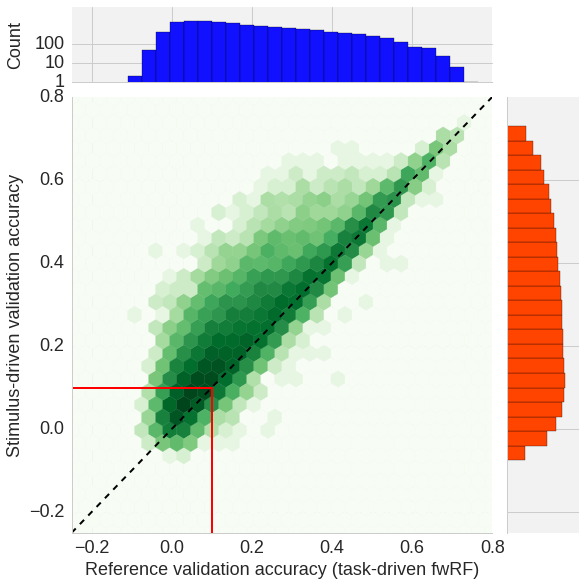

In [32]:
cc_th = 0.1
print "S[ref_cc>%.2f] = %d" % (cc_th, np.sum(ref_val_cc>cc_th))
print "S[val_cc>%.2f] = %d" % (cc_th, np.sum(val_cc>cc_th))
from src.plots import plot_pretty_compare
g=plot_pretty_compare(ref_val_cc, val_cc, cc_th, [-.25, .8], [-.25,.8], cmap='Greens')
g.ax_joint.set_xlabel('Reference validation accuracy (task-driven fwRF)')
g.ax_joint.set_ylabel('Stimulus-driven validation accuracy')

## fwRF-paper-like model 'advantage' comparision

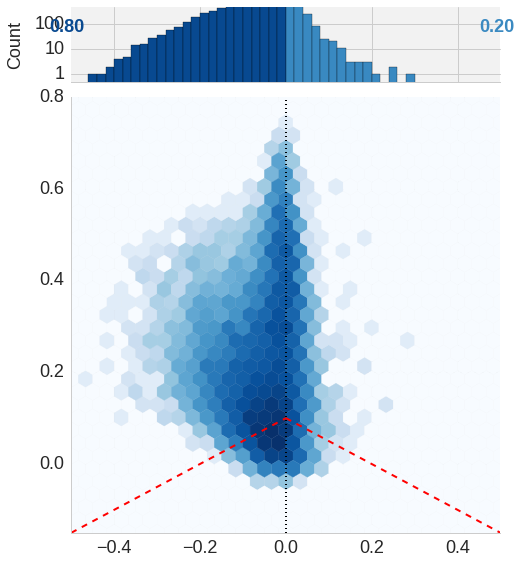

In [34]:
from src.plots import plot_fwrf_paper_compare
g=plot_fwrf_paper_compare(ref_val_cc, val_cc, cc_th, [-.5, .5], [-.15,.8])

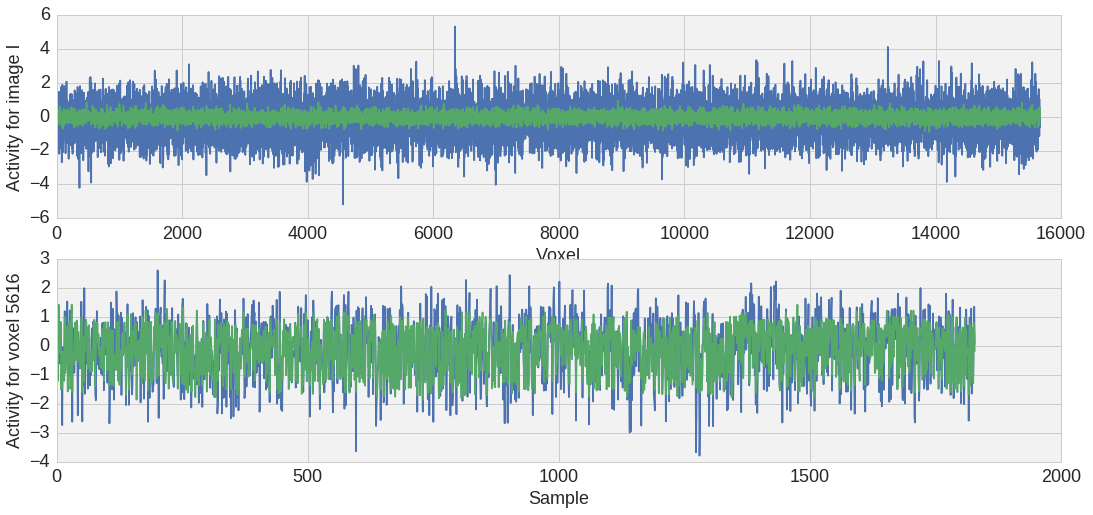

In [35]:
vidxes = np.argsort(val_cc)
plt.figure(figsize=(18,8))
plt.subplot(2,1,1)
plt.plot(val_vpc_data[0,:])
plt.plot(val_vpc_pred[0,:])
plt.xlabel('Voxel')
plt.ylabel('Activity for image I')
plt.subplot(2,1,2)
plt.plot(val_vpc_data[:,vidxes[-1]])
plt.plot(val_vpc_pred[:,vidxes[-1]])
plt.xlabel('Sample')
plt.ylabel('Activity for voxel %d'%vidxes[-1])

# Example: Map back some data into nifty format

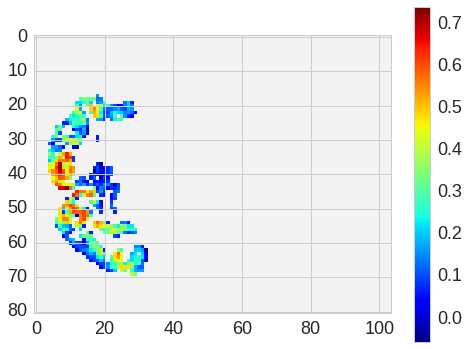

In [36]:
filename = output_dir + "val_cc_%s" % (timestamp)
volume_val_cc  = view_data(volume_r2.shape, vpc_idx, val_cc, save_to=filename)

slice_idx = 40
fig = plt.figure(figsize=(8,6))
plt.imshow(volume_val_cc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

# Voxel activation maximization pixel-gradient

In [37]:
roi_idx = []
for roi_mask, roi_name in iterate_roi(roi_group, vpc_roi, roi_map):
    cc_idx = np.arange(len(val_cc))[roi_mask]
    roi_idx += [cc_idx[np.argsort(val_cc[roi_mask])],]
    print roi_name, "\t: ", roi_idx[-1][-5:]

V1v-V1d 	:  [ 1909 11750  8938  6055  5616]
V2v-V2d 	:  [14947  4926  7429  9477  5476]
V3v-V3d 	:  [13942  8953  2375  4037  3718]
hV4 	:  [  967  6828 15451 11713  6455]
VO1-VO2 	:  [12924  7286  7630     0  1623]
PHC1-PHC2 	:  [ 9042  8371 11516  6527  5951]
MST 	:  [11965  1718  8971  4587  7683]
hMT 	:  [ 730 6198  129 3776 6052]
LO2-LO1 	:  [13287 11126  5078  4509 14028]
V3b-V3a 	:  [  773   220  2676 11300   673]
IPS0-IPS1-IPS2-IPS3-IPS4-IPS5 	:  [12546 11273 14457 12160 10331]


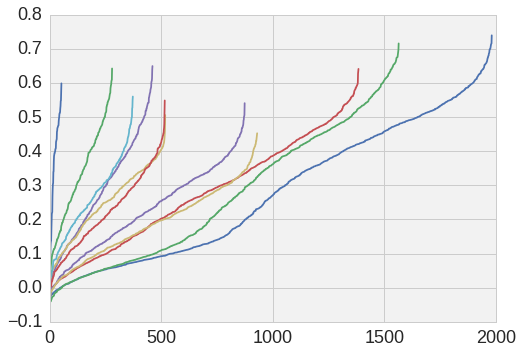

In [38]:
for r in roi_idx:
    plt.plot(val_cc[r])

# Example: Pixel gradient
We have a differentiable model with respect to pixel values
## Redefine the fwRF model to work on one voxel at a time

In [41]:
_fmaps = [L.get_output(fm, deterministic=False) for fm in fmaps]
### define factorization of global linear model over feature maps
_r, _fwrf_params = _fwrf(_fmaps, fmaps_shapes, rf_rez=(n_pix, n_pix), nv=1) # nonlinearity=lambda _x: T.log(1+T.sqrt(T.abs_(_x)))

_params = _map_params + _fwrf_params
print _params

1024 13 13
[l1.W, l1.b, l2.W, l2.b, l3.W, l3.b, l4.W, l4.b, l5.W, l5.b, l6.W, l6.b, xyRF, fRF, bias]


In [42]:
print 'COMPILING'
t = time.time()
_loss = T.sum(T.abs_(_r))
gradX_fn = theano.function([_X], T.grad(_loss, wrt=_X))
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
12.07 seconds to compile theano functions


## Chose voxel and load its parameters

In [43]:
vidx = 5616
X = val_stim_data[:20]

for k in range(len(fwrf_params)):
    param = np.copy(fwrf_params[k][vidx, np.newaxis])
    _fwrf_params[k].set_value(param)

gradX = gradX_fn(X)
print np.min(gradX), np.max(gradX)
print gradX.shape
print gradX.dtype

-0.00041416133 0.0005531993
(20, 3, 227, 227)
float32


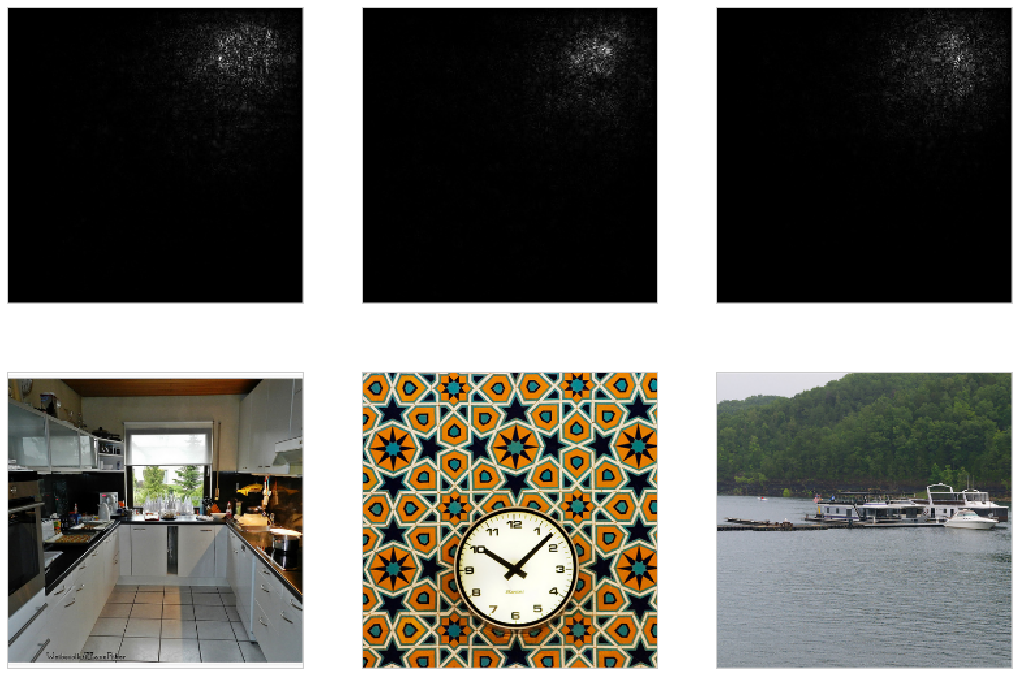

In [44]:
n = 3
plt.figure(figsize=(18,12))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(np.mean(np.abs(gradX[n+i]).transpose((1,2,0)),axis=2), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(2,3,3+i+1)
    plt.imshow(X[n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [45]:
n_steps = 200
step_size = fpX(1e2)
x = np.clip(np.random.normal(0.,0.05,size=X.shape).astype(fpX), 0., 1.)
for t in range(n_steps):
    gradX = gradX_fn((x * 255.).astype(np.uint8))
    x = np.clip(x + gradX * step_size, 0., 1.)

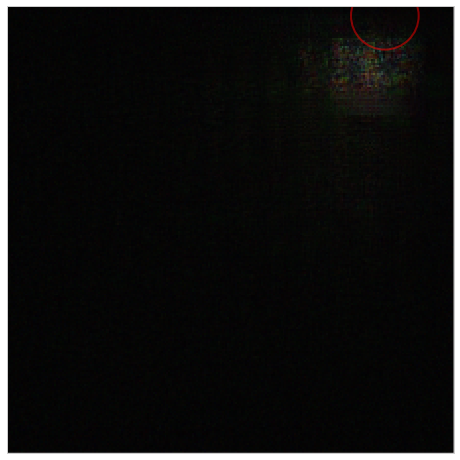

In [46]:
R = (np.mean(x, axis=0) * 255.).astype(np.uint8)
plt.figure(figsize=(8,8))    
plt.imshow(R.transpose((1,2,0)), cmap='gray', interpolation='None')
c = plt.Circle(((0.5+ref_rf_params[vidx,0])*X.shape[2], (0.5-ref_rf_params[vidx,1])*X.shape[2]), ref_rf_params[vidx,2]*X.shape[2],\
               color='r', fill=False, alpha=0.5, lw=2.)
plt.gca().add_artist(c)  
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)